In [13]:
import numpy as np
import sys
sys.path.append("../scratch_2")
from common.layers import MatMul

In [3]:
c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
h = np.matmul(c,W)
print(h)
print(W)

[[-0.12061177  2.01199021  1.90027099]]
[[-0.12061177  2.01199021  1.90027099]
 [ 0.9285594  -0.15668082  0.48758171]
 [ 0.89719587  0.18087077  0.94169314]
 [ 1.87902431 -0.88668164  0.38030872]
 [-0.73923681  1.52389862  0.40944297]
 [ 1.18061369  2.34010011 -2.04424258]
 [ 1.38755454 -0.1717398  -0.72139993]]


가중치의 행벡터 하나를 뽑아낸 것과 같다

In [14]:
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.12061177  2.01199021  1.90027099]]


In [15]:
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파 -> 편향이 없는 상태이므로 완전 연결계층 처리가 MatMul layer의 순전파와 같음
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 *(h0+h1)
s = out_layer.forward(h)

print(s)

[[ 0.60616112 -0.080469    0.79890414 -0.23682013 -0.78288412  0.25583451
  -0.99053421]]


### CBOW 모델이란?

CBOW는 continuous bag of words를 말하는데, **맥락으로부터 타깃을 추측하는 용도의 신경망**이다.
여기서 맥락은 타깃 주변단어들을 말한다. CBOW모델을 가능한 정확하게 추론하도록 훈련시켜서 단어들의 분산표현을 얻어내는것이 목표이다.

cf. 타깃으로 부터 맥락을 추측하는 용도의 신경망은 skip-gram이다

따라서 입력이 맥락(주변단어)가 되는데, 이때 형식은 원핫 벡터이다.
모델을 구성할때는 은닉층의 뉴런수가 입력층의 뉴런수보다 적게 하는 것이 핵심인데, 이렇게 하면 밀집벡터 표현을 얻을 수 있기 때문입니다.(sparse matrix형식을 유지하게 되면 메모리 사용량도 크고 계산이 오래걸린다.)

**CBOW 모델의 추론과정**을 간단히 적어보면
1. 필요한 가중치를 초기화 한다.(입력층->은닉층, 은닉층->출력층)
2. 입력층을 처리하는 MatMul 계층을 맥락수 만큼 만든다. (모두 같은 가중치를 사용)
3. 출력층의 MatMul은 하나만 생성한다. (입력층에서 처리된 값을 평균하여 사용하기 때문)
4. 각 계층을 차례로 통과시켜(forward) 각 단어의 점수를 구한다.
5. (점수에 softmax함수를 적용하면 각 단어가 등장할 확률로 표현이 가능하다.)

**CBOW 모델의 학습과정**을 간단히 적어보면,
Softmax 함수와 Cross Entropy Error 계층을 추가하여 loss function으로 사용한다.
loss fuction의 값이 줄어드는 방향으로 가중치를 조절해 나가면 된다. 


### 맥락과 타깃

word2vec에서 이용하는 신경망의 입력은 '맥락'이고, 정답 레이블은 맥락에 둘러쌓인 중앙의 단어 '타깃'이다.
따라서 맥락이 입력되었을때, 타깃이 출현할 확률을 높이는 것이 목표이다.
(샘플 데이터에서 맥락수는 여러개가 될 수도 있으나 타깃은 오직 하나이다.)

In [8]:
import numpy as np

In [2]:
import sys
sys.path.append("../scratch_2")
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)


[0 1 2 3 4 1 5 6]


In [3]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [5]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size +1):
            if t == 0:
                continue
                
            cs.append(corpus[idx+t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [9]:
contexts , target = create_contexts_target(corpus, window_size = 1)

In [11]:
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [13]:
import sys
sys.path.append('../scratch_2')
from common.util import convert_one_hot

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [14]:
print(contexts)
print(target)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]
[[[1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0]]]


In [1]:
import sys
sys.path.append('../scratch_2')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None
        

In [37]:
# import nltk
# from nltk.corpus import stopwords


def preprocess(text):
    sw_nltk = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    text = text.lower()
    text = text.replace('.', ' .')
    words = [word for word in text.split() if word not in sw_nltk ]
    
    preprocessed_words = []
    for word in words:           
        new_string = ''.join(char for char in word if char.isalnum() and not char.isdigit())
        if new_string =='':
            continue
        preprocessed_words.append(new_string)

    word_to_id = {}
    id_to_word = {}
    for word in preprocessed_words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in preprocessed_words])

    return corpus, word_to_id, id_to_word


| 에폭 1 |  반복 1 / 48 | 시간 0[s] | 손실 4.63
| 에폭 1 |  반복 21 / 48 | 시간 0[s] | 손실 4.63
| 에폭 1 |  반복 41 / 48 | 시간 0[s] | 손실 4.63
| 에폭 2 |  반복 1 / 48 | 시간 0[s] | 손실 4.63
| 에폭 2 |  반복 21 / 48 | 시간 0[s] | 손실 4.63
| 에폭 2 |  반복 41 / 48 | 시간 0[s] | 손실 4.63
| 에폭 3 |  반복 1 / 48 | 시간 0[s] | 손실 4.63
| 에폭 3 |  반복 21 / 48 | 시간 0[s] | 손실 4.63
| 에폭 3 |  반복 41 / 48 | 시간 0[s] | 손실 4.63
| 에폭 4 |  반복 1 / 48 | 시간 0[s] | 손실 4.63
| 에폭 4 |  반복 21 / 48 | 시간 0[s] | 손실 4.63
| 에폭 4 |  반복 41 / 48 | 시간 0[s] | 손실 4.62
| 에폭 5 |  반복 1 / 48 | 시간 0[s] | 손실 4.62
| 에폭 5 |  반복 21 / 48 | 시간 0[s] | 손실 4.61
| 에폭 5 |  반복 41 / 48 | 시간 0[s] | 손실 4.61
| 에폭 6 |  반복 1 / 48 | 시간 0[s] | 손실 4.61
| 에폭 6 |  반복 21 / 48 | 시간 0[s] | 손실 4.59
| 에폭 6 |  반복 41 / 48 | 시간 0[s] | 손실 4.60
| 에폭 7 |  반복 1 / 48 | 시간 0[s] | 손실 4.58
| 에폭 7 |  반복 21 / 48 | 시간 0[s] | 손실 4.58
| 에폭 7 |  반복 41 / 48 | 시간 0[s] | 손실 4.56
| 에폭 8 |  반복 1 / 48 | 시간 0[s] | 손실 4.55
| 에폭 8 |  반복 21 / 48 | 시간 0[s] | 손실 4.56
| 에폭 8 |  반복 41 / 48 | 시간 0[s] | 손실 4.50
| 에폭 9 |  반복 1 / 48 | 시간

C:\Users\fibik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fibik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fibik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fibik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fibik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fibik\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48373 missing from cur

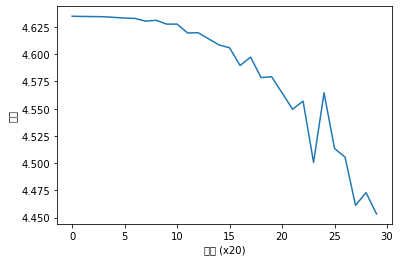

In [19]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 10
batch_size = 3
max_epoch = 10

file = open("sample_text.txt", "r")
file = file.readlines()
#text = 'You say goodbye and I say hello.'

text_in_line=""
for t in file:
    text_in_line += t
    
corpus, word_to_id, id_to_word = preprocess(text_in_line)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# word_vecs = model.word_vecs
# for word_id, word in id_to_word.items():
#     print(word, word_vecs[word_id])



In [20]:
# 학습이 끝난후 매개변수 출력

word_vecs = model.word_vecs
# for word_id , word in id_to_word.items():
#     print(word, word_vecs[word_id])

In [5]:
word_vecs.shape

(103, 5)

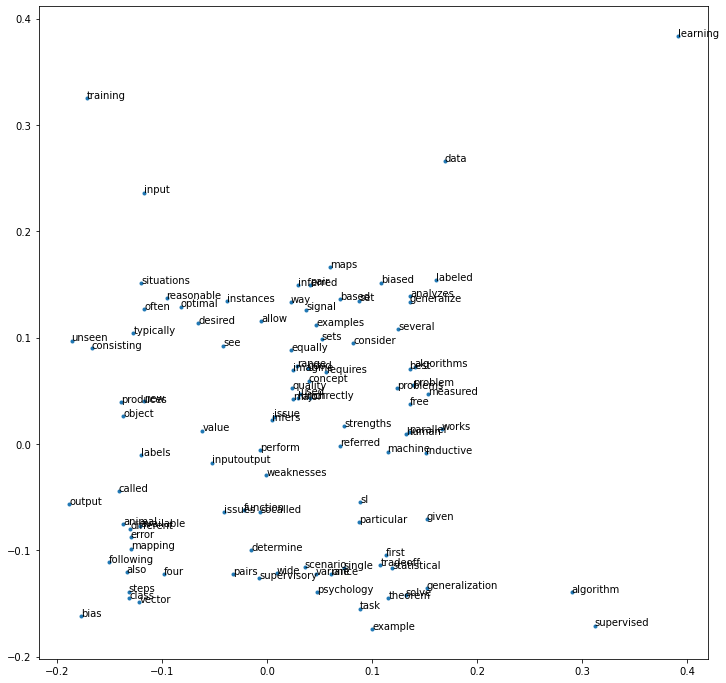

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for word, word_id in word_to_id.items():
    plt.annotate(word, (word_vecs[word_id,0], word_vecs[word_id,1]))


plt.plot(word_vecs[:,0], word_vecs[:,1], '.' )

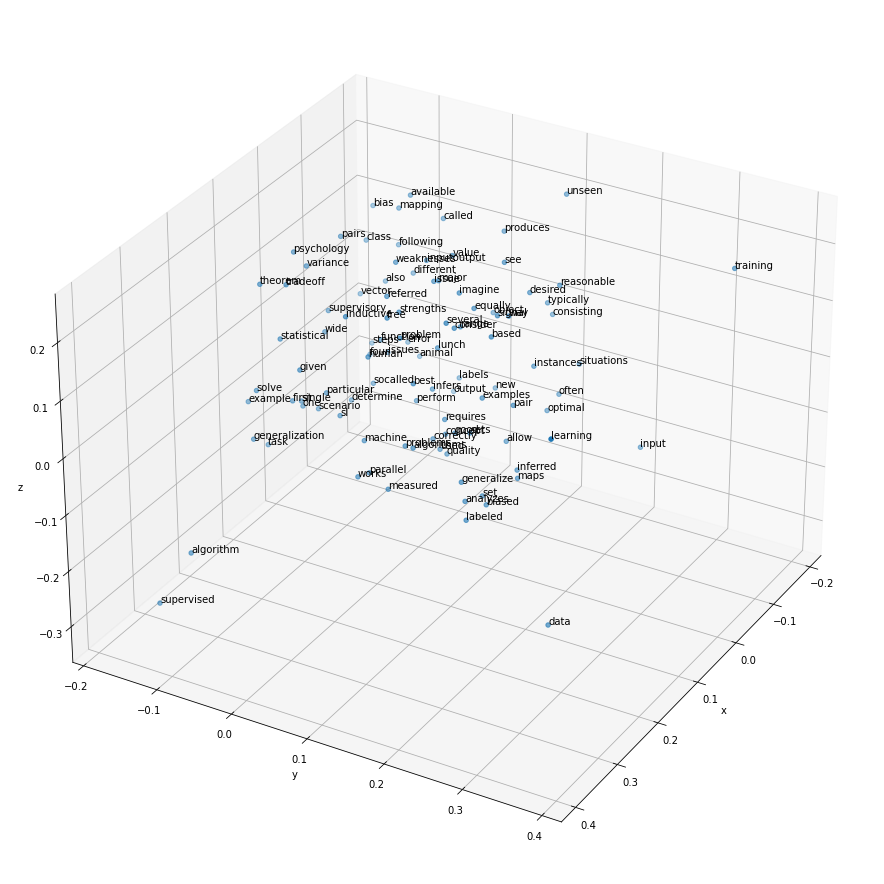

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection='3d')

for word, word_id in word_to_id.items():
    ax.text(word_vecs[word_id,0], word_vecs[word_id,1], word_vecs[word_id,2], word)

ax.scatter(word_vecs[:,0], word_vecs[:,1],word_vecs[:,2], '.' )

# ax.set_xlim3d(-0.25, 0.25)
# ax.set_ylim3d(-0.25, 0.25)
# ax.set_zlim3d(-0.25, 0.25)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.view_init(30, 30)
plt.show()



In [23]:
word_vecs.shape

(103, 10)

In [24]:
from common.util import most_similar

querys = ['learning', 'machine', 'training', 'supervised']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] learning
 problem: 0.8975393176078796
 consider: 0.880955159664154
 range: 0.8067222833633423
 best: 0.7752035856246948
 signal: 0.7547795176506042

[query] machine
 sl: 0.9709960222244263
 supervised: 0.9629333019256592
 algorithm: 0.9259185791015625
 task: 0.9033446907997131
 solve: 0.8930699825286865

[query] training
 produces: 0.8687240481376648
 optimal: 0.8494879007339478
 consisting: 0.8315750956535339
 maps: 0.6529134511947632
 unseen: 0.6522273421287537

[query] supervised
 algorithm: 0.9768248796463013
 machine: 0.9629333019256592
 sl: 0.9629058837890625
 task: 0.9557828307151794
 one: 0.954744815826416
